In [64]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torchvision.models import efficientnet_b7, EfficientNet_B7_Weights

import pandas as pd
import copy
import numpy as np

import shutil
import os
from PIL import Image
from tqdm import tqdm
from google.cloud import storage
from collections import defaultdict


storage_client = storage.Client("leo_font")
bucket = storage_client.bucket("leo_font")

In [2]:
import os
from tqdm import tqdm
from google.cloud import storage

def download_files_from_folder(bucket, gcp_path, local_file_path):
    if os.path.exists(local_file_path):
        print(f"The file {local_file_path} exists.")
    else:
        print(f"{local_file_path} downloaded")
        blob = bucket.blob(gcp_path)
        blob.download_to_filename(local_file_path)

# Example usage
gcpfd = "effnet_exp"
localfd = "/home/jupyter/ai_font/data/model"
model0 = "effnet_11.pth"
model1 = "effproto_50000.pth"
download_files_from_folder(bucket, f"{gcpfd}/{model0}", f"{localfd}/{model0}")
download_files_from_folder(bucket, f"{gcpfd}/{model1}", f"{localfd}/{model1}")


/home/jupyter/ai_font/data/model/effnet_11.pth downloaded
/home/jupyter/ai_font/data/model/effproto_50000.pth downloaded


In [18]:
def get_all_korean():

    def nextKorLetterFrom(letter):
        lastLetterInt = 15572643
        if not letter:
            return '가'
        a = letter
        b = a.encode('utf8')
        c = int(b.hex(), 16)

        if c == lastLetterInt:
            return False

        d = hex(c + 1)
        e = bytearray.fromhex(d[2:])

        flag = True
        while flag:
            try:
                r = e.decode('utf-8')
                flag = False
            except UnicodeDecodeError:
                c = c+1
                d = hex(c)
                e = bytearray.fromhex(d[2:])
        return e.decode()

    returns = []
    flag = True
    k = ''
    while flag:
        k = nextKorLetterFrom(k)
        if k is False:
            flag = False
        else:
            returns.append(k)
    return returns

def euclidean_dist(x, y):
    '''
    Compute euclidean distance between two tensors
    '''
    # x: N x D
    # y: M x D
    n = x.size(0)
    m = y.size(0)
    d = x.size(1)
    if d != y.size(1):
        raise Exception

    x = x.unsqueeze(1).expand(n, m, d)
    y = y.unsqueeze(0).expand(n, m, d)

    return torch.pow(x - y, 2).sum(2)

class ImageConcat:
    def __init__(self, n_h, n_v, resolution=1000):
        self.n_h = n_h
        self.n_v = n_v
        self.r = resolution
        self.img = Image.new("RGB", (self.n_h*self.r, self.n_v*self.r))
        self.cursor = [0,0]    
    
    def move_cursor_h(self):
        self.cursor[0] += self.r
        
    def move_cursor_v(self):
        self.cursor[1] += self.r
        
    def reset_cursor_h(self):
        self.cursor[0] = 0
        
    def append_img(self, path):
        try:
            self.img.paste(Image.open(path).convert('RGB'), tuple(self.cursor))
        except:
            # print(f"Not Appended: {path}")
            pass
        
    def save_img(self, path):
        self.img.save(path)

In [47]:
def korean2label(letter):
    ch0 = ord(letter) - ord('가')
    ch1 = (ord(letter) - ord('가'))//588
    ch2 = ((ord(letter) - ord('가')) - (588*ch1)) // 28
    ch3 = (ord(letter) - ord('가')) - (588*ch1) - 28*ch2
    return ch1,ch2,ch3

In [44]:
def letter2index(letter):
    return ord(letter) - ord('가')

In [32]:
ak = get_all_korean()

In [37]:
korean_mapper = []
for l in ak:
    ch = korean2label(l)
    korean_mapper.append({
        'letter': l,
        'index':ch[3],
        "초성": ch[0],
        "중성": ch[1],
        "종성": ch[2],
    })

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [6]:
class CustomDataset(Dataset):
    def __init__(self, files, transform=None):
        self.transform = transform
        self.files = files
        
    def __len__(self):
        # return int(len(self.files)/100)
        return len(self.files)

    def __getitem__(self, idx):
        path = self.files[idx]
        image = Image.open(path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image

In [7]:
class LetterClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.effnet = efficientnet_b7(weights=EfficientNet_B7_Weights.IMAGENET1K_V1)
        in_features = 1000
        self.cho_fc = nn.Linear(in_features, 19)
        self.jung_fc = nn.Linear(in_features, 21)
        self.jong_fc = nn.Linear(in_features, 28)

    def forward(self, x):
        x = self.effnet(x)
        cho_out = self.cho_fc(x)
        jung_out = self.jung_fc(x)
        jong_out = self.jong_fc(x)
        return cho_out, jung_out, jong_out

In [8]:
class StyleMeasurer(nn.Module):
    def __init__(self):
        super().__init__()
        self.effnet = efficientnet_b7(weights=EfficientNet_B7_Weights.IMAGENET1K_V1)

    def forward(self, x):
        x = self.effnet(x)
        return torch.tanh(x)

In [9]:
letter_classifier = LetterClassifier()
letter_classifier = letter_classifier.to(device)
style_measurer = StyleMeasurer()
style_measurer = style_measurer.to(device)

In [10]:
letter_classifier.load_state_dict(torch.load(f"{localfd}/{model0}"))
letter_classifier.eval()

LetterClassifier(
  (effnet): EfficientNet(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        (2): SiLU(inplace=True)
      )
      (1): Sequential(
        (0): MBConv(
          (block): Sequential(
            (0): Conv2dNormActivation(
              (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=64, bias=False)
              (1): BatchNorm2d(64, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
              (2): SiLU(inplace=True)
            )
            (1): SqueezeExcitation(
              (avgpool): AdaptiveAvgPool2d(output_size=1)
              (fc1): Conv2d(64, 16, kernel_size=(1, 1), stride=(1, 1))
              (fc2): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
              (activation): SiLU(inplace=True)
              

In [11]:
style_measurer.load_state_dict(torch.load(f"{localfd}/{model1}"))
style_measurer.eval()

StyleMeasurer(
  (effnet): EfficientNet(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        (2): SiLU(inplace=True)
      )
      (1): Sequential(
        (0): MBConv(
          (block): Sequential(
            (0): Conv2dNormActivation(
              (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=64, bias=False)
              (1): BatchNorm2d(64, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
              (2): SiLU(inplace=True)
            )
            (1): SqueezeExcitation(
              (avgpool): AdaptiveAvgPool2d(output_size=1)
              (fc1): Conv2d(64, 16, kernel_size=(1, 1), stride=(1, 1))
              (fc2): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
              (activation): SiLU(inplace=True)
              (sc

In [13]:
import os
import numpy as np
from tqdm import tqdm
from PIL import Image
from google.cloud import storage

import sys
import importlib

def call_module(nm, path):
    spec = importlib.util.spec_from_file_location(nm, path)
    foo = importlib.util.module_from_spec(spec)
    sys.modules[nm] = foo
    spec.loader.exec_module(foo)
    return foo

In [14]:
def download_files_from_folder(bucket_name, bucket_fd, local_fd, files):
    """Download all files from a folder in a Google Cloud Storage bucket."""
    # Initialize a client
    client = storage.Client()
    # Get the bucket
    bucket = client.bucket(bucket_name)
    # List all blobs (files) in the specified folder
    for file in files:
        blob = bucket.blob(f"{bucket_fd}/{file}")
        blob.download_to_filename(f"{local_fd}/{file}")

In [15]:
model_type = 'letterstrip_fontdiffuser_training_phase_1'
model_i = '430000'
files_dict = {
    'unet': f"{model_type}__unet_{model_i}.pth",
    'content_encoder': f"{model_type}__content_encoder_{model_i}.pth",
    'style_encoder': f"{model_type}__style_encoder_{model_i}.pth",
}
local_fd = "/home/jupyter/ai_font/data/model"
os.makedirs(local_fd, exist_ok=True)
download_files_from_folder("leo_font","experiments",local_fd,list(files_dict.values()))

In [16]:
fd = "/home/jupyter/ai_font/experiments/sample"
module_fd = "/home/jupyter/ai_font/experiments/font_diffuser_letterstrip"
args = call_module('args', f"{fd}/args.py")
SampleArgs = args.SampleArgs

sample = call_module('sample', f"{fd}/sample.py")
load_fontdiffuser_pipeline = sample.load_fontdiffuser_pipeline
sampling = sample.sampling

In [17]:
args = SampleArgs()
modelpaths = {k:f"{local_fd}/{v}" for k,v in files_dict.items()}
pipe = load_fontdiffuser_pipeline(args, module_fd, modelpaths)

Load the down block  DownBlock2D
Load the down block  MCADownBlock2D
The style_attention cross attention dim in Down Block 1 layer is 1024
The style_attention cross attention dim in Down Block 2 layer is 1024
Load the down block  MCADownBlock2D
The style_attention cross attention dim in Down Block 1 layer is 1024
The style_attention cross attention dim in Down Block 2 layer is 1024
Load the down block  DownBlock2D
Load the up block  UpBlock2D
Load the up block  StyleRSIUpBlock2D
Load the up block  StyleRSIUpBlock2D
Load the up block  UpBlock2D
Param count for Ds initialized parameters: 20591296
Get CG-GAN Style Encoder!
Param count for Ds initialized parameters: 1187008
Get CG-GAN Content Encoder!
Loaded the model state_dict successfully!
Loaded training DDPM scheduler sucessfully!
Loaded dpm_solver pipeline sucessfully!


In [43]:
reportfd = "/home/jupyter/ai_font/data/test_ttf/report"
contentfd = "/home/jupyter/ai_font/data/zipfiles/raw/size96/seen"
stylefd = "/home/jupyter/ai_font/data/test_ttf/pngs"
filterfd = "/home/jupyter/ai_font/data/test_ttf/filter"
os.makedirs(reportfd, exist_ok=True)

In [82]:
test_sentence0 = "동해물과백두산이마르고닳도록"
test_sentence1 = "하느님이보우하사우리나라만세"

In [83]:
fonts = ["어비나현체","어비뒤죽박죽체","어비퀸제이체","잉크립퀴드체","신동엽시인체"]

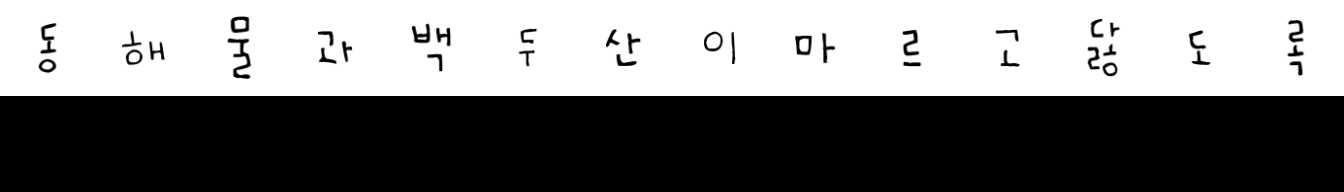

In [84]:
bimg = ImageConcat(n_h=len(test_sentence0), n_v=2, resolution=96)
for i in range(len(test_sentence0)):
    bimg.append_img(f"{stylefd}/{font}__{test_sentence0[i]}.png")
    bimg.move_cursor_h()
bimg.reset_cursor_h()
bimg.move_cursor_v()
bimg.move_cursor_v()
for i in range(len(test_sentence1)):
    bimg.append_img(f"{stylefd}/{font}__{test_sentence1[i]}.png")
    bimg.move_cursor_h()
bimg.img

In [ ]:
# for k in 
for font in fonts:
    pbar = tqdm(test_sentence0)
    for k in pbar:
        label = korean2label(k)
        c = letter2index(k)
        files = [(f.split("__")[-1].replace(".png",""), f"{stylefd}/{f}") 
                 for f in os.listdir(stylefd) if (font in f) & (f"__{k}" not in f) &(".png" in f)]
        tempdict = defaultdict(list)
        # pbar = tqdm(files)
        while len(tempdict['path']) < 5:
        # for l, filepath in pbar:
            pbar.set_postfix(letter=k,filtered=len(tempdict['path']),font=font)
            l, filepath = files[np.random.choice(np.arange(len(files)),1)[0]]
            img = sampling(
                args=args, 
                pipe=pipe, 
                content_image=Image.open(f"{contentfd}/gulim__{c}.png").convert("RGB"),
                style_image=Image.open(filepath).convert("RGB"),
                verbose = False)
            pred = letter_classifier(transform(img).unsqueeze(0).cuda())
            if np.all([torch.argmax(p).item()==l for p,l in zip(pred,label)]):
                # emb = style_measurer(transform(img).unsqueeze(0).cuda()).detach().cpu()
                # dist = euclidean_dist(emb, prototypes[font])
                savefilepath = f"{filterfd}/{font}__c{k}__s{l}.png"
                tempdict['path'].append(savefilepath)
                # tempdict['dist'].append(dist.item())
                tempdict['img'].append(img)
                
        for imgi in range(len(tempdict['path'])):
            tempdict['img'][imgi].save(tempdict['path'][imgi])
        # best_i = np.argmin(tempdict['dist'])
        # tempdict['img'][best_i].save(tempdict['path'][best_i])


 29%|██▊       | 4/14 [10:58<32:09, 193.00s/it, filtered=4, font=잉크립퀴드체, letter=백]

In [77]:
files[np.random.choice(np.arange(len(files)),1)[0]]

('텁', '/home/jupyter/ai_font/data/test_ttf/pngs/잉크립퀴드체__텁.png')

In [72]:
np.array(tempdict['dist'])[np.argsort(tempdict['dist'])]

array([1057.07824707, 1065.28625488, 1072.8638916 , 1082.36303711,
       1084.53356934, 1085.8482666 , 1088.21801758, 1088.93432617,
       1089.74475098, 1093.26586914, 1094.48693848, 1095.45458984,
       1095.84594727])

In [62]:
prototypes[font]

tensor([[-4.5301e-01,  8.4744e-01, -9.7366e-01,  6.7075e-01, -1.8675e-01,
          8.5763e-01,  4.2691e-01, -8.3155e-02,  1.0306e-02,  6.6529e-01,
         -7.0408e-01, -8.3286e-01,  1.7136e-02, -1.3596e-02, -1.0189e-02,
          8.9520e-01,  9.3545e-01, -3.0724e-01,  9.3657e-01, -1.0131e-01,
          7.8131e-01,  8.1514e-01,  9.3289e-01,  8.9638e-01, -1.1479e-01,
          7.8894e-01,  7.6586e-01,  8.0414e-01, -5.9490e-02,  3.8514e-01,
         -9.2703e-01, -8.2843e-01,  8.2420e-01,  8.6110e-01,  6.6727e-02,
          7.8817e-01,  6.6279e-01,  9.3033e-01,  6.9507e-01,  9.7303e-01,
          6.1186e-01,  4.8033e-01,  9.3829e-01, -9.4648e-01, -7.6758e-01,
          8.4850e-01, -8.3432e-01,  9.4545e-01, -5.1124e-01,  9.1669e-01,
         -8.8599e-01, -9.6142e-01, -9.2468e-01,  9.2111e-01, -8.3467e-01,
         -8.1572e-02,  9.2944e-01,  9.8393e-01,  7.3860e-01,  7.2465e-01,
          2.5240e-02,  4.6533e-01,  6.8260e-01,  8.6466e-01,  3.6785e-01,
          4.2356e-01, -8.8711e-01, -9.

In [15]:
files = [f"{reportfd}/{f}" for f in os.listdir(reportfd)]

In [18]:
batchsize = 16

In [46]:
model_type = [
    "vanilla_fontdiffuser_training_phase_1",
    "oskar_fontdiffuser_training_phase_1",
    "letterstrip_fontdiffuser_training_phase_1"][-1]
for font in config.test_fonts:
    protofiles = [f"{datafd}/{f}" for f in os.listdir(datafd) if (font in f)]
    ds = CustomDataset(protofiles, transform=transform)
    c = 0
    embs = []
    while c < len(ds):
        imgs = []
        for _ in range(batchsize):
            if c < len(ds):
                imgs.append(ds[c])
                c += 1
        embs.append(style_measurer(torch.stack(imgs).cuda()).detach().cpu())
    proto = torch.concat(embs).mean(0,keepdim=True)
    print("got proto")
    for s in ["seen","unseen"]:
        contents = config.seens_ids if s == "seen" else config.unseens_ids
        for c in contents:
            classifyfiles = [f for f in files if (f"_c{c}" in f) & (font in f) & (model_type in f)]
            cds = CustomDataset(classifyfiles, transform=transform)
            label = korean2label(config.ak[c])
            any_passed_files = []
            all_passed_files = []
            for img_idx in range(len(cds)):
                pred = letter_classifier(cds[img_idx].unsqueeze(0).cuda())
                if np.any([torch.argmax(p).item()==l for p,l in zip(pred,label)]):
                    any_passed_files.append(cds.files[img_idx])
                    if np.all([torch.argmax(p).item()==l for p,l in zip(pred,label)]):
                        all_passed_files.append(cds.files[img_idx])
            print(f"all passed: {len(all_passed_files)}\t any passed: {len(any_passed_files)}")
            if len(all_passed_files) > 0:
                passed_files = all_passed_files
                sds = CustomDataset(passed_files, transform=transform)
                embeds = []
                for img_idx in range(len(sds)):
                    embeds.append(style_measurer(sds[img_idx].unsqueeze(0).cuda()).detach().cpu())
                dist = euclidean_dist(torch.concat(embeds).detach().cpu(), proto)
                savepath = f"{savefd}/{model_type}__{font}__{c}.png"
                shutil.copy(passed_files[torch.argmin(dist).item()], savepath)
                print(f"file saved: {savepath}")
            elif len(any_passed_files) > 0:
                passed_files = any_passed_files
                sds = CustomDataset(passed_files, transform=transform)
                embeds = []
                for img_idx in range(len(sds)):
                    embeds.append(style_measurer(sds[img_idx].unsqueeze(0).cuda()).detach().cpu())
                dist = euclidean_dist(torch.concat(embeds).detach().cpu(), proto)
                savepath = f"{savefd}/{model_type}__{font}__{c}.png"
                shutil.copy(passed_files[torch.argmin(dist).item()], savepath)
                print(f"file saved: {savepath}")
            else:
                print(f"file not selected: {model_type}__{font}__{c}")

got proto
all passed: 36	 any passed: 100
file saved: /home/jupyter/ai_font/data/report3/letterstrip_fontdiffuser_training_phase_1__twice dahyun_4__1288.png
all passed: 29	 any passed: 91
file saved: /home/jupyter/ai_font/data/report3/letterstrip_fontdiffuser_training_phase_1__twice dahyun_4__3164.png
all passed: 2	 any passed: 100
file saved: /home/jupyter/ai_font/data/report3/letterstrip_fontdiffuser_training_phase_1__twice dahyun_4__4228.png
all passed: 51	 any passed: 99
file saved: /home/jupyter/ai_font/data/report3/letterstrip_fontdiffuser_training_phase_1__twice dahyun_4__6832.png
all passed: 7	 any passed: 100
file saved: /home/jupyter/ai_font/data/report3/letterstrip_fontdiffuser_training_phase_1__twice dahyun_4__8792.png
all passed: 48	 any passed: 94
file saved: /home/jupyter/ai_font/data/report3/letterstrip_fontdiffuser_training_phase_1__twice dahyun_4__9632.png
all passed: 78	 any passed: 100
file saved: /home/jupyter/ai_font/data/report3/letterstrip_fontdiffuser_training_

In [47]:
model_type = [
    "vanilla_fontdiffuser_training_phase_1",
    "oskar_fontdiffuser_training_phase_1",
    "letterstrip_fontdiffuser_training_phase_1"][0]
for font in config.test_fonts:
    protofiles = [f"{datafd}/{f}" for f in os.listdir(datafd) if (font in f)]
    ds = CustomDataset(protofiles, transform=transform)
    c = 0
    embs = []
    while c < len(ds):
        imgs = []
        for _ in range(batchsize):
            if c < len(ds):
                imgs.append(ds[c])
                c += 1
        embs.append(style_measurer(torch.stack(imgs).cuda()).detach().cpu())
    proto = torch.concat(embs).mean(0,keepdim=True)
    print("got proto")
    for s in ["seen","unseen"]:
        contents = config.seens_ids if s == "seen" else config.unseens_ids
        for c in contents:
            classifyfiles = [f for f in files if (f"_c{c}" in f) & (font in f) & (model_type in f)]
            cds = CustomDataset(classifyfiles, transform=transform)
            label = korean2label(config.ak[c])
            any_passed_files = []
            all_passed_files = []
            for img_idx in range(len(cds)):
                pred = letter_classifier(cds[img_idx].unsqueeze(0).cuda())
                if np.any([torch.argmax(p).item()==l for p,l in zip(pred,label)]):
                    any_passed_files.append(cds.files[img_idx])
                    if np.all([torch.argmax(p).item()==l for p,l in zip(pred,label)]):
                        all_passed_files.append(cds.files[img_idx])
            print(f"all passed: {len(all_passed_files)}\t any passed: {len(any_passed_files)}")
            if len(all_passed_files) > 0:
                passed_files = all_passed_files
                sds = CustomDataset(passed_files, transform=transform)
                embeds = []
                for img_idx in range(len(sds)):
                    embeds.append(style_measurer(sds[img_idx].unsqueeze(0).cuda()).detach().cpu())
                dist = euclidean_dist(torch.concat(embeds).detach().cpu(), proto)
                savepath = f"{savefd}/{model_type}__{font}__{c}.png"
                shutil.copy(passed_files[torch.argmin(dist).item()], savepath)
                print(f"file saved: {savepath}")
            elif len(any_passed_files) > 0:
                passed_files = any_passed_files
                sds = CustomDataset(passed_files, transform=transform)
                embeds = []
                for img_idx in range(len(sds)):
                    embeds.append(style_measurer(sds[img_idx].unsqueeze(0).cuda()).detach().cpu())
                dist = euclidean_dist(torch.concat(embeds).detach().cpu(), proto)
                savepath = f"{savefd}/{model_type}__{font}__{c}.png"
                shutil.copy(passed_files[torch.argmin(dist).item()], savepath)
                print(f"file saved: {savepath}")
            else:
                print(f"file not selected: {model_type}__{font}__{c}")

got proto
all passed: 29	 any passed: 100
file saved: /home/jupyter/ai_font/data/report3/vanilla_fontdiffuser_training_phase_1__twice dahyun_4__1288.png
all passed: 38	 any passed: 94
file saved: /home/jupyter/ai_font/data/report3/vanilla_fontdiffuser_training_phase_1__twice dahyun_4__3164.png
all passed: 2	 any passed: 100
file saved: /home/jupyter/ai_font/data/report3/vanilla_fontdiffuser_training_phase_1__twice dahyun_4__4228.png
all passed: 64	 any passed: 100
file saved: /home/jupyter/ai_font/data/report3/vanilla_fontdiffuser_training_phase_1__twice dahyun_4__6832.png
all passed: 8	 any passed: 96
file saved: /home/jupyter/ai_font/data/report3/vanilla_fontdiffuser_training_phase_1__twice dahyun_4__8792.png
all passed: 27	 any passed: 94
file saved: /home/jupyter/ai_font/data/report3/vanilla_fontdiffuser_training_phase_1__twice dahyun_4__9632.png
all passed: 69	 any passed: 99
file saved: /home/jupyter/ai_font/data/report3/vanilla_fontdiffuser_training_phase_1__twice dahyun_4__1094

In [48]:
import zipfile

In [ ]:
import zipfile
import os

def zip_folder(folder_path, zip_path):
    # Create a ZipFile object
    with zipfile.ZipFile(zip_path, 'w', zipfile.ZIP_DEFLATED) as zipf:
        # Iterate over the files and subdirectories within the folder
        for root, dirs, files in os.walk(folder_path):
            for file in files:
                # Get the full path of the file
                file_path = os.path.join(root, file)
                # Add the file to the zip archive
                zipf.write(file_path, os.path.relpath(file_path, folder_path))

# Specify the folder to be zipped and the path for the resulting zip file
folder_to_zip = savefd
zip_file_path = f"{savefd}/zipped.zip"

# Call the function to zip the folder
zip_folder(folder_to_zip, zip_file_path)

print(f"Folder '{folder_to_zip}' zipped successfully to '{zip_file_path}'.")
